<a href="https://colab.research.google.com/github/patrick013/Image-Classification-CNN-and-VGG/blob/master/Dog_vs_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow-gpu

In [ ]:
    import os
    import glob
    # my all files starts with "frame" and ends with ".jpg"
    fileList = glob.glob('/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train/cat/*.*')
    print("Number of files: ",len(fileList))

    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

Number of files:  0


# Image Classification Using CNN


![VGG](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
print(tf.__version__)

2.18.0


## Prepare Data

The dataset has been split into two parts - training set which contains 2,000 images of damaged and non_damaged eyeshadows boxs. In this project, the model is trained on the training set and tested on test set which includes 1,500 images.

In [ ]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

Cloning into 'Image-Classification-CNN-and-VGG'...
remote: Enumerating objects: 37510, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 37510 (delta 43), reused 36 (delta 7), pack-reused 37414 (from 1)
Receiving objects: 100% (37510/37510), 812.51 MiB | 35.84 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (50016/50016), done.


In [ ]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'damaged':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [ ]:
df=get_pathframe("Image-Classification-CNN-and-VGG/dataset/dataset/")
df.tail(5)

,filename,category,paths
103,damaged (35).jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
104,damaged (53).jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
105,damaged (111).jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
106,damaged (105).jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
107,damaged (6).jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...


In [ ]:
def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [ ]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

### Check Images

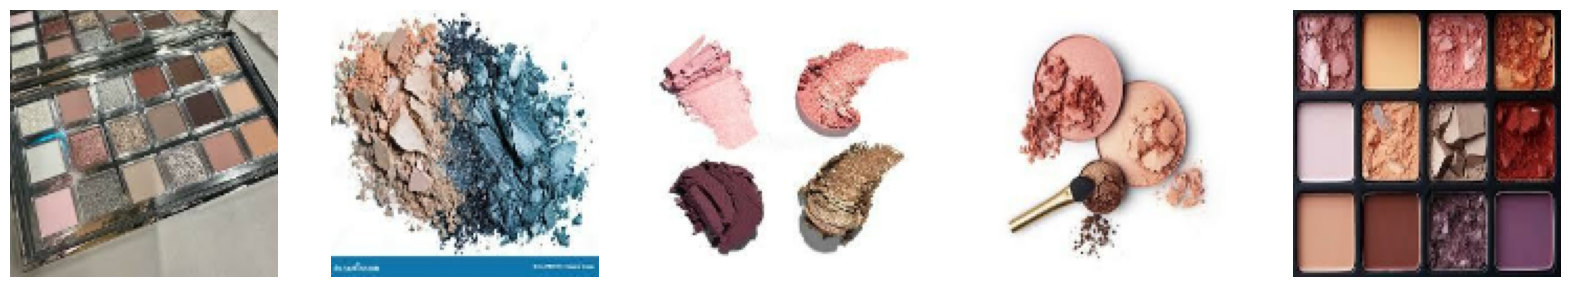

In [ ]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

## Convolutional Neural Networks
### Build Network

The architecture of CNN used in this project is shown as follow (PS: fully connected network is not shown on the picture):
![mynetwork](https://raw.githubusercontent.com/patrick013/Image-Classification-CNN-and-VGG/master/pictures/mycnnmodel.png)

In [ ]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
model=My_CNNmodel()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,705 (8.10 MB)

 Trainable params: 2,122,705 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
os.makedirs('/content/drive/My Drive/DPprojects/damagvsnon_damaged')

In [ ]:
hist=model.fit(dataset_train,epochs=20,validation_data=dataset_test)
# model.save("/content/drive/My Drive/DPprojects/damagvsnon_damaged/my_model")
# Mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

# ... (Your existing code) ...

# Save your model.

model.save("/content/drive/My Drive/DPprojects/damagvsnon_damaged/my_model.keras") # Add the .keras extension to the file path

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 0.7265
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.2893
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0608
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.4835e-04
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 8.1631e-06
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.2225e-07
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.3491e-08
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 1.9035e-10
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 1.0000 - loss: 5.0889e-12
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.6565e-15
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1679e-15
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.2765e-16
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/s

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):

    # Check if 'val_accuracy' exists in the history keys, if not, use 'val_acc'
    if val_acc not in model_history.history.keys():
        val_acc = 'val_acc'

    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [ ]:
hist=model.fit(dataset_train,epochs=20,validation_data=dataset_test, validation_split=0.2)  # Add validation_split or validation_data

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 6.4966e-28
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 1.3501e-33
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 4.2762e-30
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 4.4617e-36
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 1.0000 - loss: 1.4310e-31
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.2734e-32
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.0825e-41
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 1.0000 - loss: 5.4982e-34
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 1.0000 - loss: 3.7387e-35
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 1.0000 - loss: 7.1466e-44
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 1.0000 - loss: 6.4256e-36
Epoch 12/20
1/1 ━━━━━━━━━━━━━━

<Axes: >

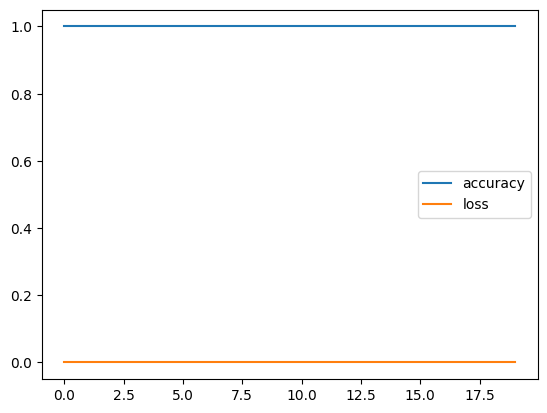

In [ ]:
import pandas as pd
pd.DataFrame(model.history.history).plot()

In [ ]:
model.save("/content/drive/My Drive/DPprojects/DogvsCats/model.h5")

### Overfitting

Obviously, my model is overfitted! To overcome the problem of overfitting, there are some ways to do:
1. Expand dataset
2. Use regularization
3. Add dropout layers


```
tf.keras.layers.Dropout(0.5)
```
4. Use batchnormalization


```
tf.keras.layers.BatchNormalization()
```



### Evaluation

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Horizontal Flip

Found 1749 images belonging to 3 classes.


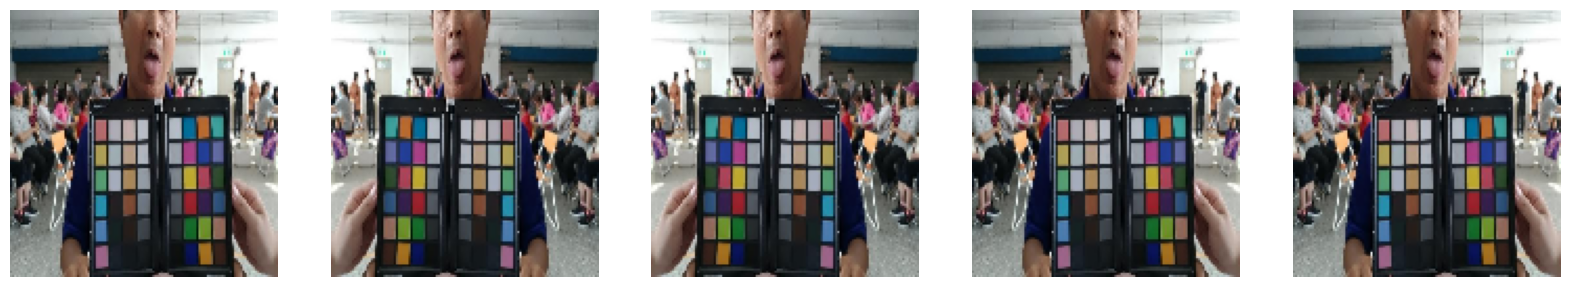

In [ ]:
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Rotation

Found 1749 images belonging to 3 classes.


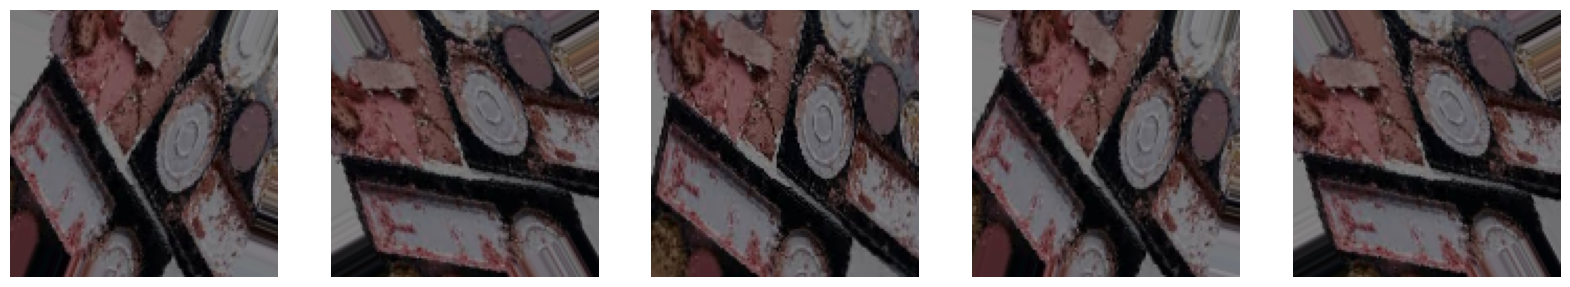

In [ ]:
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory="/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                       shuffle=True,
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Zoom Augmentation

Found 1749 images belonging to 3 classes.


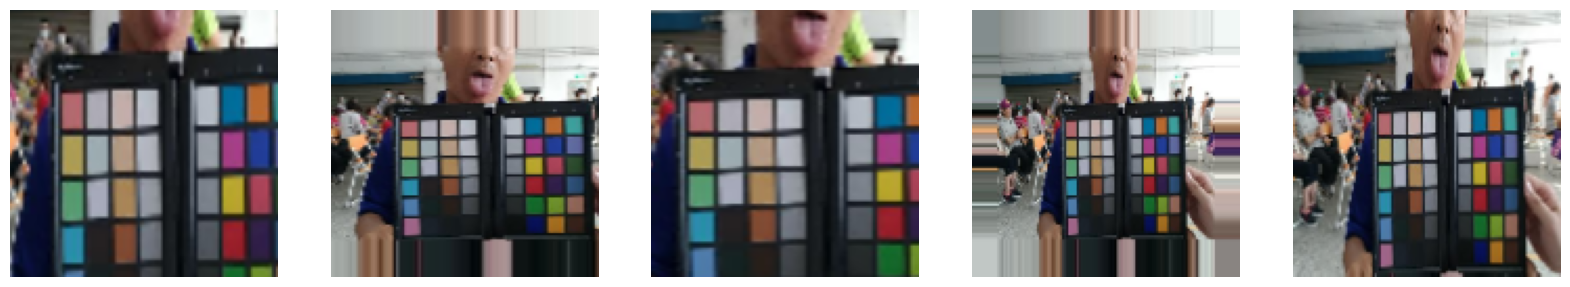

In [ ]:
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Pull Together

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
validation_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="/content/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/validation",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

Found 1749 images belonging to 3 classes.
Found 291 images belonging to 3 classes.


###Retrain

## Transfer Learning - VGG16

The output of dataset should be changed!

### Training

### Evaluation


## Summary
Obviously, VGG wins! My model to some degress is overfitted, which means the accuracy on training set is higher than that on validation set. To solve this problem:
1. Batch Normalization
2. Dropout
3. Regularization

### Big Challenge - Loss does not change

The biggest challenge that I met was that there was not a sign that the loss tended to decrease at all after 10 epochs when I was using VGG network. I spent whole night to fix this problem and tried many suggestions online, such as check the dataset labels, reducing the networks and so on. However, it didn't work at all. One of the reason was that I forgot to convert y label to one hot array.